This notebook is an implementation of a continuous Hopfield network for the purpose of remembering images.

It uses the continuous updating rule of $\tau_i \frac{dV_i}{dt} = -V_i + g_\beta (u_i) = -V_i + g_\beta (\sum_j W_{ij}V_j)$

Cheat sheet:

- $V$ is a vector of all the neurons. In our case, each neuron represents a pixel where the value is between $[-1, 1]$
- $g_\beta$ is a continuous non-linear function. In our case, we use tanh, which outputs values between $[-1, 1]$
- $W$ is the symmetric weight matrix representing the connections between neurons. $W_{ii} = 0$ and $W_{ij} = W_{ji}$. It is initialized by setting $W_{ij} = V_iV_j$ where $V$ is initialized to the state you want the network to "memorize". If you want the network to remember multiple of these states, simply set $W$ to the sum of all the $W$ matrices, one computed for each state.


In [2]:
import numpy as np

# Grayscale

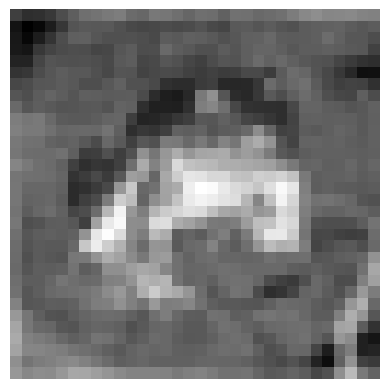

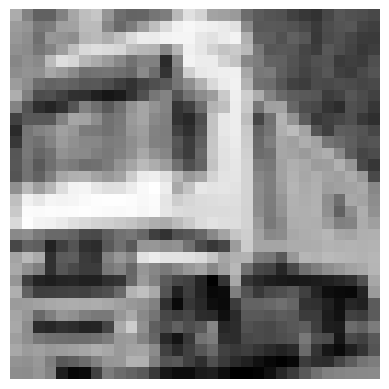

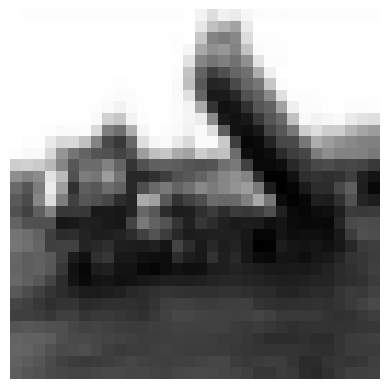

In [ ]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 3
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

for i in range(num_images):
    grayscale_img = np.mean(data[i].reshape((3,1024)), axis=0)
    X = np.hstack((X, grayscale_img.reshape(-1, 1)))
    grayscale_img = grayscale_img.reshape((32,32))
    plt.imshow(grayscale_img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
    grayscale_img = (grayscale_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(grayscale_img)

color_enabled = False
num_neurons = 1024
W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    image_normalized = image / np.linalg.norm(image)
    W += np.outer(image_normalized, image_normalized) 

W = W / num_images

np.fill_diagonal(W, 0)

# Color

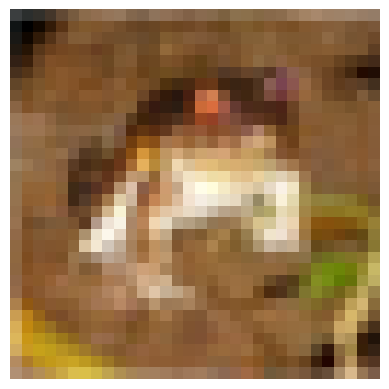

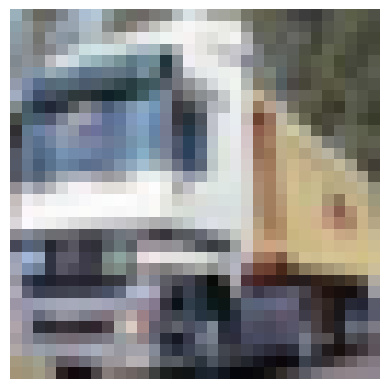

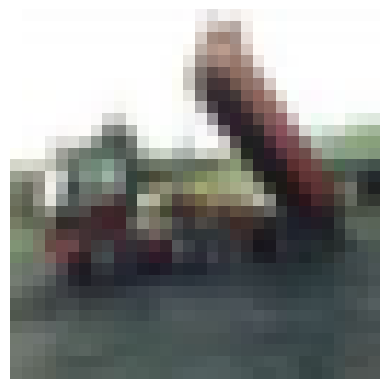

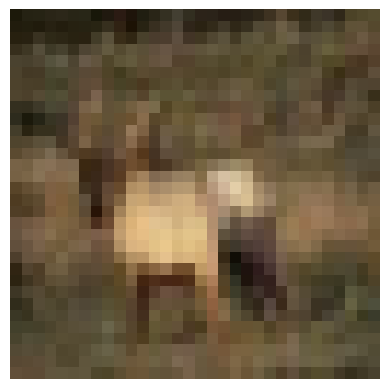

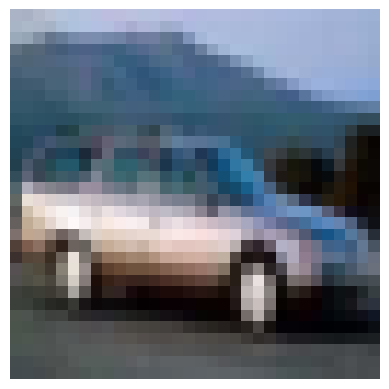

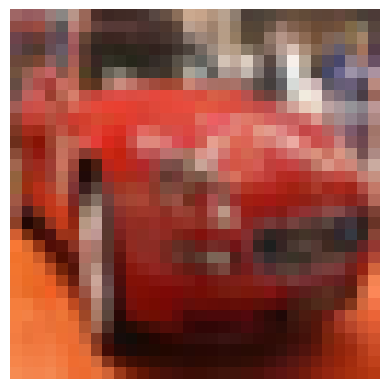

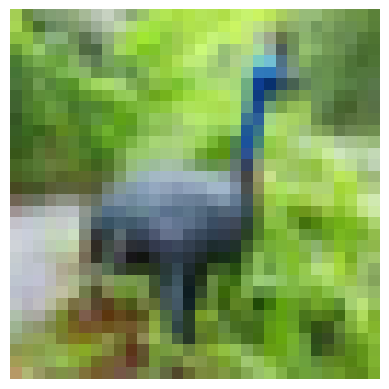

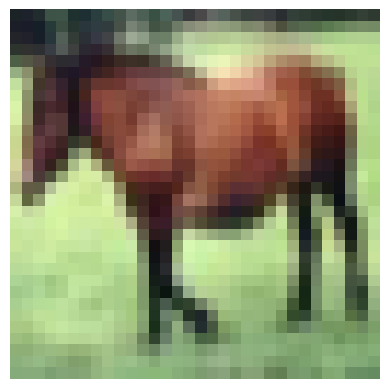

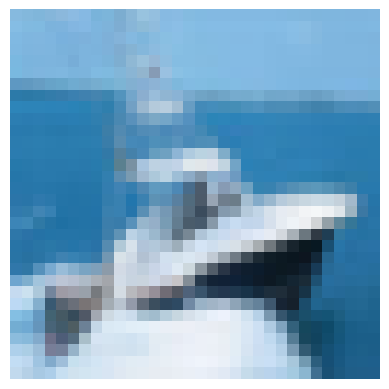

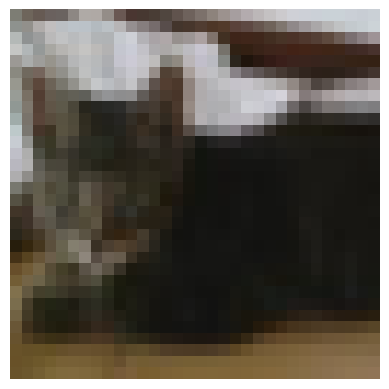

In [415]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 10
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

for i in range(num_images):
    color_img = data[i].reshape((3,32,32)).transpose(1,2,0)    
    plt.imshow(color_img, interpolation='none')
    plt.axis('off')
    plt.show()
    X = np.hstack((X, color_img.flatten().reshape(-1, 1)))
    color_img = (color_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(color_img)


W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    image_normalized = image / np.linalg.norm(image)
    W += np.outer(image_normalized, image_normalized) 


W = W / num_images

np.fill_diagonal(W, 0)

# Extremely distinct images

In [281]:
from scipy.integrate import solve_ivp

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# constants
def g(u, beta = 7):
    return np.tanh(u * beta)

def sigmoid(u, scaling_factor=2):
    return 1 / (1 + np.exp(-u / scaling_factor))

def energy(v):
    return -0.5 * g(v).T @ W @ g(v) + np.sum(np.log(np.cosh(v)))

tol = 1e-4 # integrate until converging to this tolerance
dt = 0.001

def hopfield_diff_eq(t, v):
    dvdt = (-v + W @ g(v))
    return dvdt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


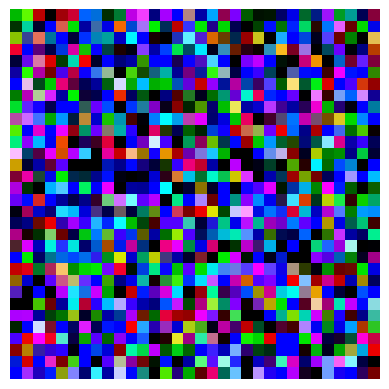

In [282]:
# If you want random noise, choose the top V. If you want to start it at a specific image, choose the bottom V.

V = np.random.uniform(-1.0, 1.0, size=(num_neurons))
# V = images[2].flatten()
# choice = np.random.choice(len(images))
# print(choice)
# V = images[choice].flatten()

# bluer V
V = np.random.uniform(-1.0, 1.0, size=(num_neurons)).reshape(32, 32, 3)
V[:,:, 2] += 0.5
V = V.reshape(3072)


time = 0 # for integration, this is the starting time at first
times = [time]
states = [V]

current_state = V
prev_state = V + 2 * tol # This makes the first iteration of the loop work

# while np.abs(current_state - prev_state).max() > tol:
#     prev_state = current_state
#     result = solve_ivp(hopfield_diff_eq, (time, time + dt), current_state, method='RK45', t_eval=[time+dt])
    
#     current_state = result.y[:, -1]
#     time += dt
#     times.append(time)
#     # states.append(current_state)
#     # current_state = prev_state + hopfield_diff_eq(0, prev_state) * dt
#     states.append(current_state)


result = solve_ivp(hopfield_diff_eq, (0, 100), current_state, method='RK45', t_eval=[100])
states.append(result.y[:, -1])

times = np.array(times)
states = np.array(states)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


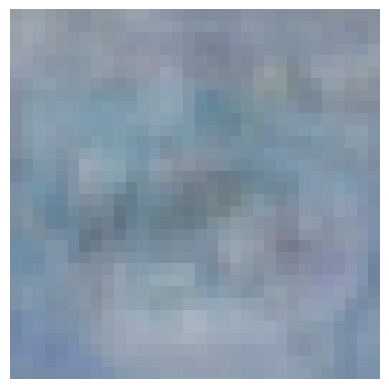

In [283]:
if color_enabled:
    final_img = states[-1].reshape((32,32,3))
else:
    final_img = states[-1].reshape((32,32))

final_img = (final_img+1)/2

if color_enabled:
    plt.imshow(final_img, interpolation='none')
else:
    plt.imshow(final_img, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [26]:
def invert(image):
    return 1-image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


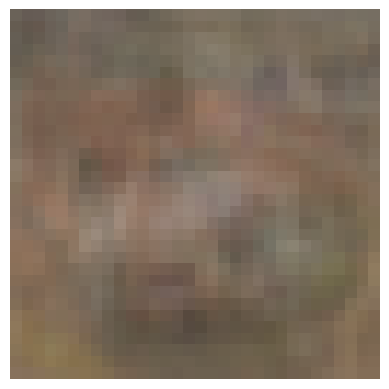

In [263]:
negative = invert(final_img)

if color_enabled:
    plt.imshow(negative, interpolation='none')
else:
    plt.imshow(negative, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [264]:
for image in images:
    print(cosine_similarity(final_img.flatten(), image.flatten()))

-0.494532144632739
0.018819212847012108
0.08106848660224104
-0.8310007822988416
-0.37610003165430167
-0.5892251502245595
-0.1879099234215986
-0.127535758369217
0.41921511804214767
-0.7118951554379563


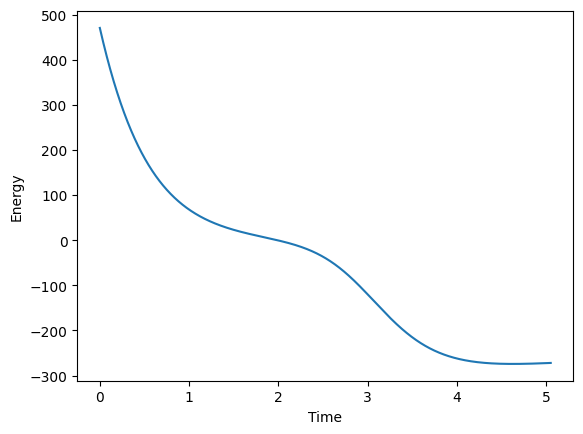

In [216]:
energies = [energy(state) for state in states]
plt.plot(times, energies)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

# Hopfield Networks is all you need

In [424]:
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def modern_hopfield_step(X,xi,beta=0.001):
    xinew = X@softmax(beta*X.T@xi)
    return xinew

In [433]:
# V = np.random.uniform(-1.0, 1.0, size=(num_neurons))
V = X[:, 4]
# choice = np.random.choice(len(images))
# print(choice)
# V = X[:, choice]

current_state = V + 0.01 * np.random.randn(*V.shape)
prev_state = V + 2 * tol

states = [current_state]

iter_count = 0

while np.abs(current_state - prev_state).max() > tol:
    iter_count += 1 
    prev_state = current_state
    current_state = modern_hopfield_step(X, prev_state)
    states.append(current_state)

print(iter_count)


2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.005887330357340977


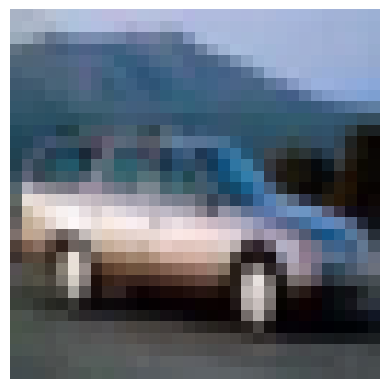

8.0


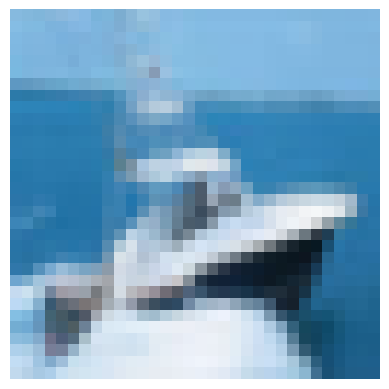

8.0


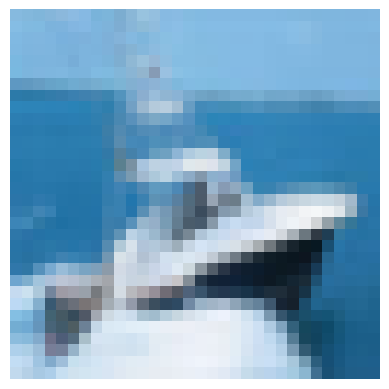

In [435]:
if color_enabled:
    for img in states:
        print(np.min(img))
        final_img = img.reshape((32,32,3)) / 255.0
        plt.imshow(final_img, interpolation='none')
        plt.axis('off')
        plt.show()
else:
    for img in states:
        final_img = img.reshape((32,32)) / 255.0
        plt.imshow(final_img, cmap="gray", interpolation='none')
        plt.axis('off')
        plt.show()

In [407]:
np.min(X)

0.0

In [306]:
current_state

array([255., 255., 255., ...,  80.,  86.,  84.])

In [345]:
V = X[:, 0]
V.shape

(3072,)

In [436]:
for i in range(X.shape[1]):
    print(np.linalg.norm(X[:,i]))

6416.603462892186
7964.367457620222
8711.389843188055
4884.421255379188
6644.910006915067
6039.182808956854
7257.420133904334
7504.499450329782
9085.38689324786
5034.667417019718


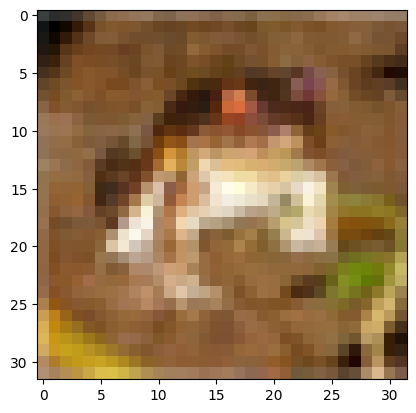

In [438]:
plt.imshow(X[:, 0].reshape((32,32,3)) / 255.0, interpolation='none')